**Name : Dhruvi Shah**

**Student ID : 202211032**

**AML Lab 8 LDA**

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [ ]:
df_rate = pd.read_csv('tripadvisor_hotel_reviews.csv')
df_rate.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


Text(0.5, 1.0, 'Ditribution of ratings')

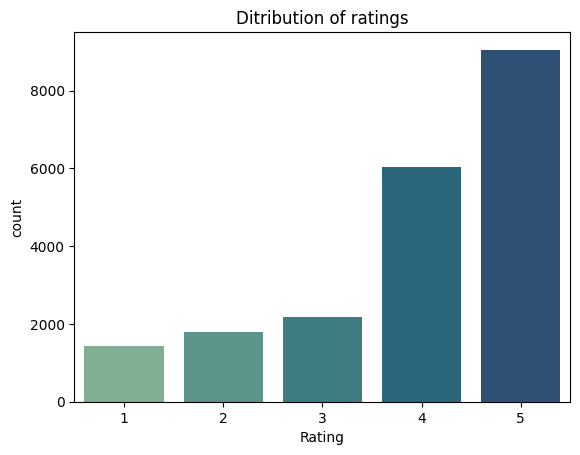

In [ ]:
sns.countplot(data=df_rate, x='Rating', palette='crest').set_title('Ditribution of ratings')

In [ ]:
df_rate['Length'] = df_rate['Review'].apply(len)
df_rate.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [ ]:
length = df_rate['Length'].sum()

#EDA

In [ ]:
def ratings(rating):
    if rating>3 and rating<=5:
        return "Positive"
    if rating>0 and rating<=3:
        return "Negative"

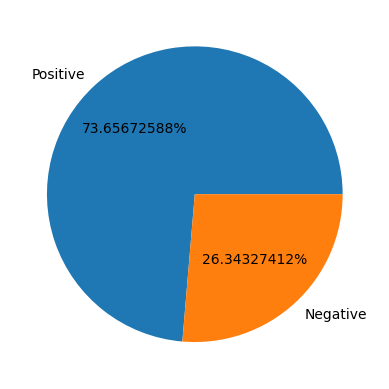

In [ ]:
df_rate['Rating'] = df_rate['Rating'].apply(ratings)
plt.pie(df_rate['Rating'].value_counts(), labels=df_rate['Rating'].unique().tolist(), autopct='%1.8f%%')
plt.show()

#Applying tokenization, stemming and lemmatization

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [ ]:
print('Original document:')
print(df_rate['Review'][0])
print()

sentence = []
for word in df_rate['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('After applying Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df_rate['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('After applying Lemmatization:')
print(' '.join(sentence))

Original document:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

After applying Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neig

**Observed difference between Stemming and Lemmatization** :           
- Stemming is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling.
e.g. from above advice changes to advic
- Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.
e.g as advic has no dictionary meaning, it remains advice 

#Removal of stop words

In [ ]:
def remove_stop(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [ ]:
df_rate['Review'] = df_rate['Review'].apply(remove_stop)

In [ ]:
df_rate['Length'] = df_rate['Review'].apply(len)
new_length = df_rate['Length'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 14853861
Total text length after cleaning: 13543965


In [ ]:
df_rate.to_csv('cleaned_df.csv', index=False)

**Making the word cloud to gain the idea of word distribution**

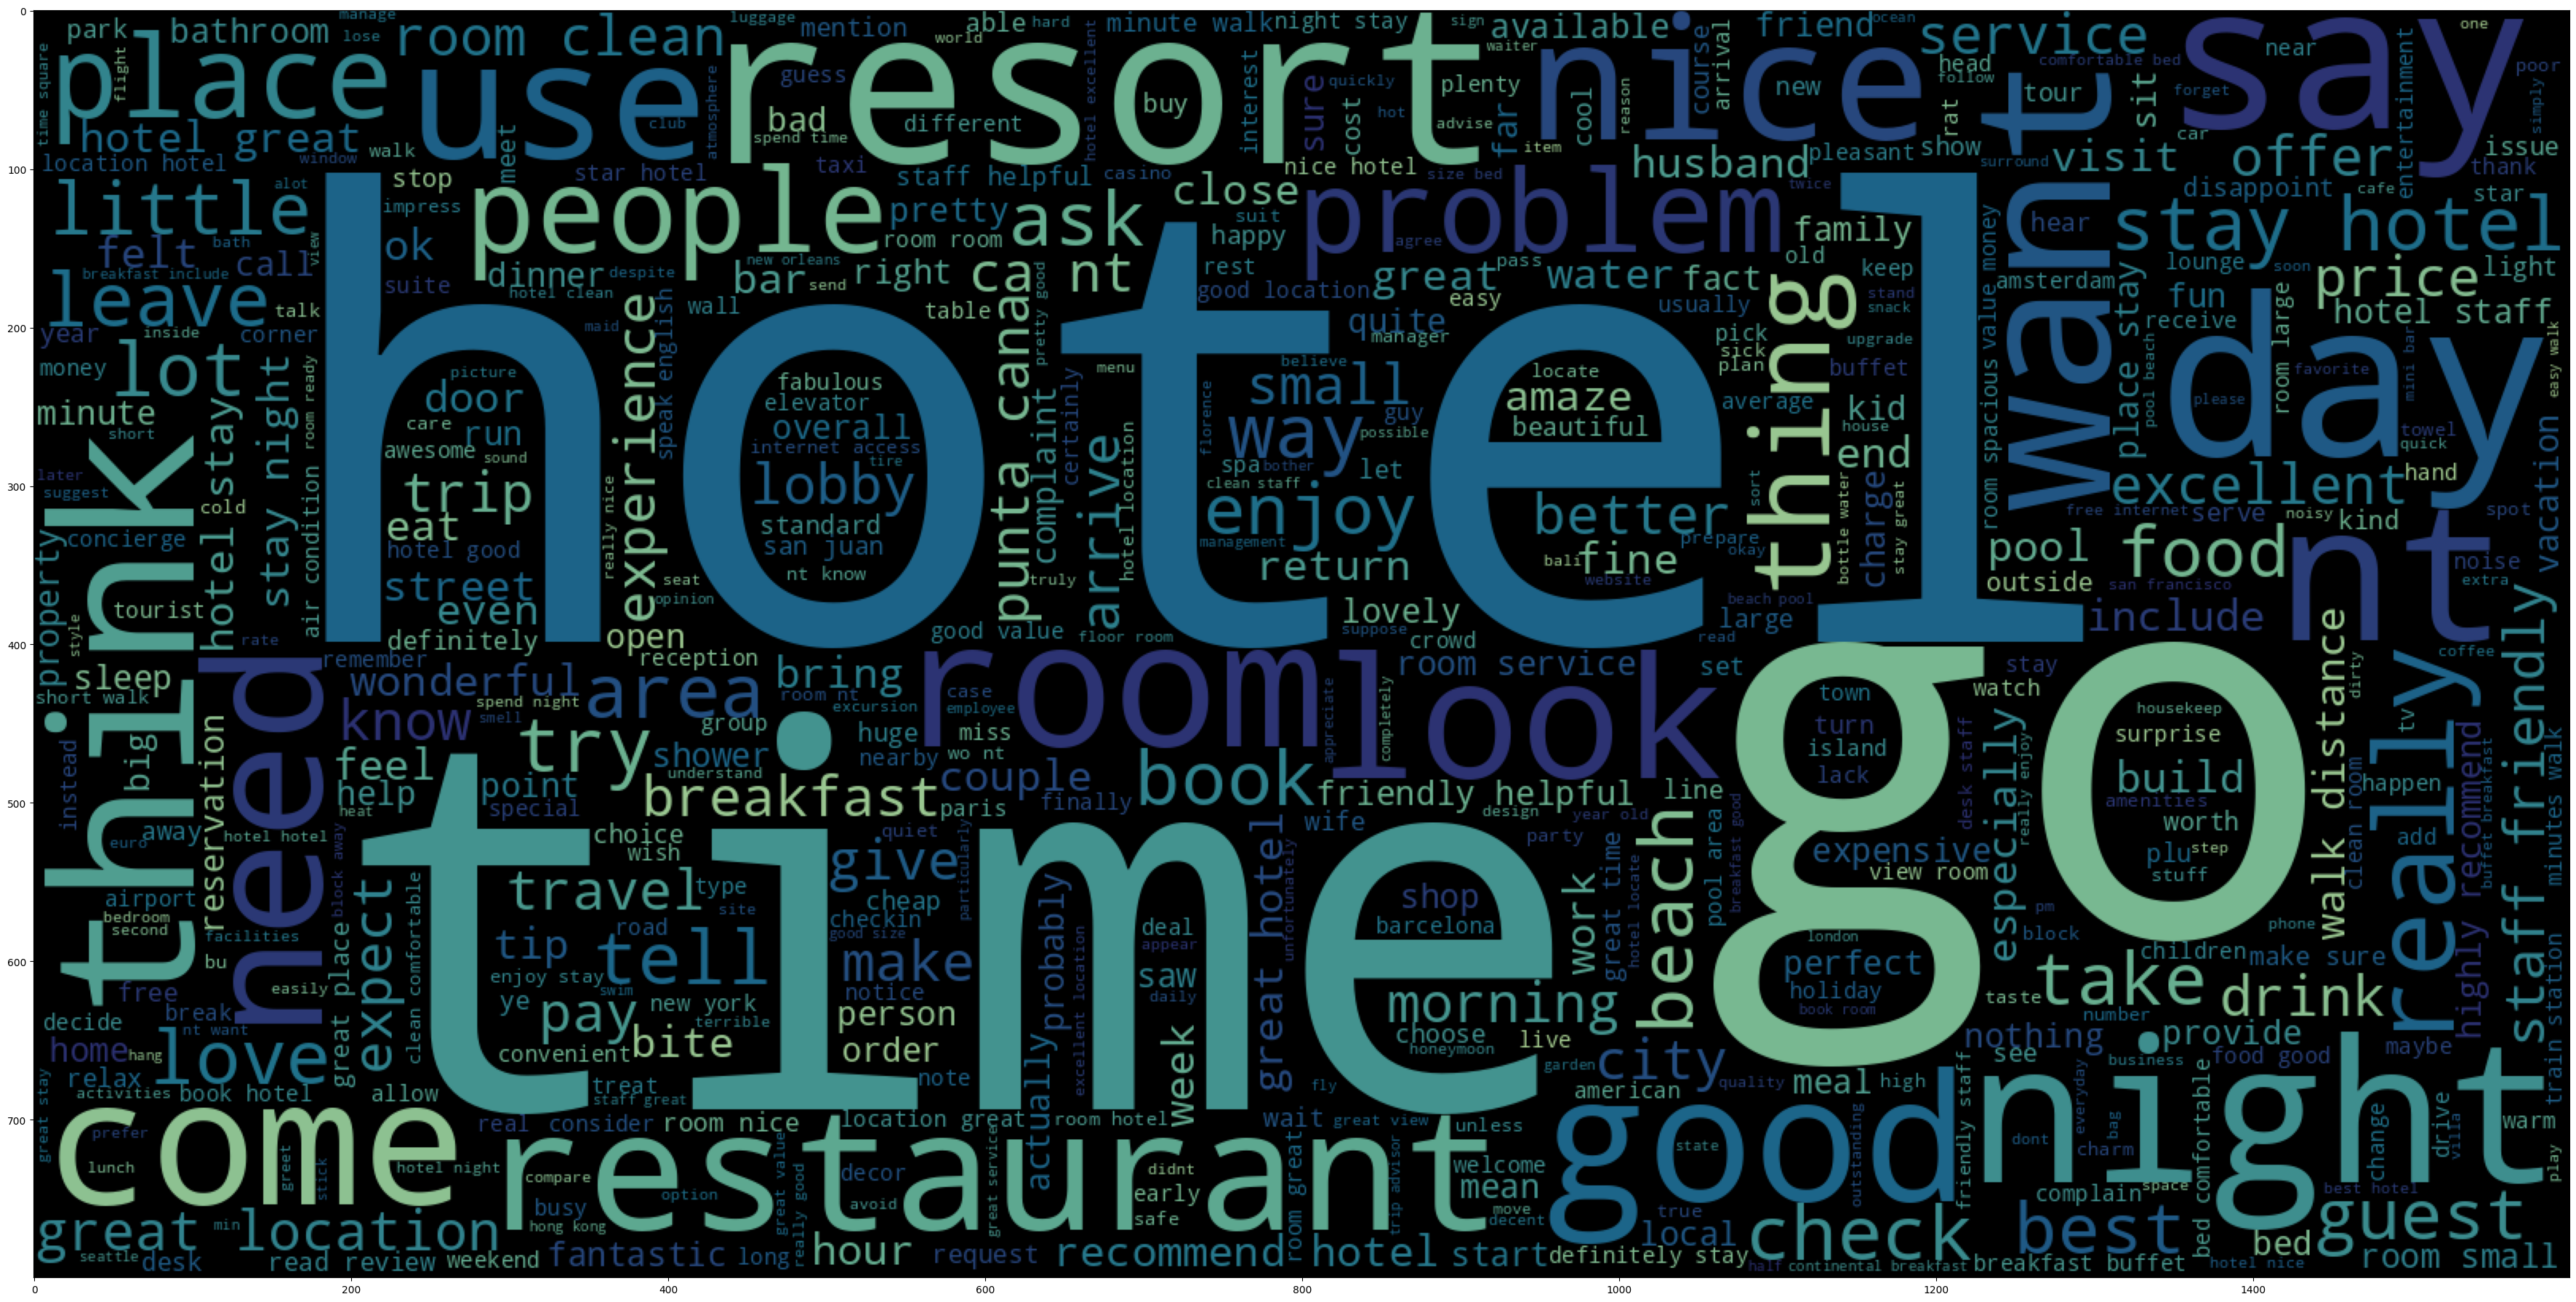

In [ ]:
plt.figure(figsize=(45,45))
wordcl = WordCloud(max_words=2000, min_font_size=8, 
                height=800,width=1600,background_color="black", colormap='crest').generate(' '.join(df_rate['Review']))
plt.imshow(wordcl)

In [ ]:
#importing libaries
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [ ]:
df_5000= df_rate[0:5000]

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_5000.Review.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['nice', 'hotel', 'expensive', 'park', 'get', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrive', 'late', 'even', 'take', 'advice', 'previous', 'review', 'valet', 'park', 'check', 'quick', 'easy', 'little', 'disappoint', 'nonexistent', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'wake', 'stiff', 'neck', 'high', 'pillow', 'soundproof', 'like', 'hear', 'music', 'room', 'night', 'morning', 'loud', 'bang', 'doors', 'open', 'close', 'hear', 'people', 'talk', 'hallway', 'maybe', 'noisy', 'neighbor', 'aveda', 'bath', 'products', 'nice', 'goldfish', 'stay', 'nice', 'touch', 'take', 'advantage', 'stay', 'longer', 'location', 'great', 'walk', 'distance', 'shop', 'overall', 'nice', 'experience', 'pay', 'park', 'night']]


In [ ]:
# Building the  bigrams models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases. 
bigram_mod = gensim.models.phrases.Phraser(bigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    #texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [ ]:
# Create Dictionary
dicttoword = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [dicttoword.doc2bow(text) for text in data_ready]


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dicttoword,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.045*"room" + 0.016*"shower" + 0.012*"tell" + 0.011*"leave" + '
  '0.010*"problem" + 0.009*"check" + 0.009*"call" + 0.009*"charge" + '
  '0.008*"ask" + 0.008*"desk"'),
 (1,
  '0.059*"hotel" + 0.038*"room" + 0.029*"stay" + 0.018*"staff" + '
  '0.016*"location" + 0.016*"great" + 0.012*"breakfast" + 0.012*"night" + '
  '0.008*"service" + 0.008*"small"'),
 (2,
  '0.018*"week" + 0.013*"bag" + 0.011*"arrange" + 0.011*"break" + '
  '0.010*"customer" + 0.009*"holiday" + 0.009*"base" + 0.009*"truly" + '
  '0.009*"simply" + 0.008*"advise"'),
 (3,
  '0.032*"quality" + 0.023*"overlook" + 0.013*"courteous" + 0.011*"lift" + '
  '0.011*"terrace" + 0.011*"exceptional" + 0.011*"barcelona" + '
  '0.009*"delightful" + 0.008*"date" + 0.008*"gracious"')]


In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.9122,"hotel, room, stay, staff, location, great, bre...","[hotel, expensive, park, deal, stay, hotel, an..."
1,1,1,0.6105,"hotel, room, stay, staff, location, great, bre...","[special, charge, diamond, member, decide, cha..."
2,2,1,0.5958,"hotel, room, stay, staff, location, great, bre...","[room, levelpositive, large, bathroom, comfort..."
3,3,1,0.8646,"hotel, room, stay, staff, location, great, bre...","[unique, great, stay, wonderful, time, hotel, ..."
4,4,1,0.5999,"hotel, room, stay, staff, location, great, bre...","[great, stay, great, stay, seahawk, game, down..."


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.7700,"room, shower, tell, leave, problem, check, call, charge, ask, desk","[horrify, stay, filthy, terrible, frighten, location, loud, towel, stain, threadbare, place, loo..."
1,1,0.9903,"hotel, room, stay, staff, location, great, breakfast, night, service, small","[excellent, hotel, hill, room, priceline, bid, pay, price, turn, great, place, stay, money, pay,..."
2,2,0.5131,"week, bag, arrange, break, customer, holiday, base, truly, simply, advise","[stay, regularly, business, equally, comfortable, leisure, trip, palace, succesfully, integrate,..."
3,3,0.4785,"quality, overlook, courteous, lift, terrace, exceptional, barcelona, delightful, date, gracious","[parrot, impress, salty, sea, dog, venture, lazy_parrot, lazy, pint, parrot, fine, establishment..."


#Word cloud for top N topics

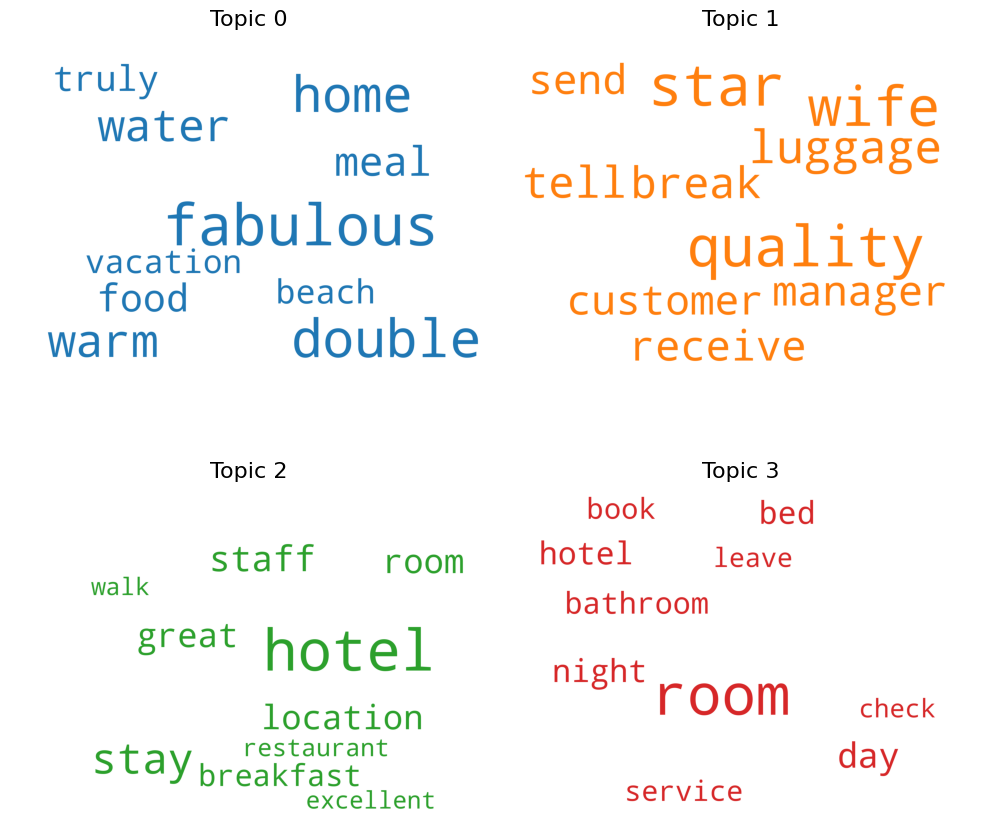

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [ ]:
text_list=df_rate['Review'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

ok nothing special charge diamond member hilton decide chain shoot 20th anniversary seattle start book suite pay extra website description suite bedroom bathroom standard hotel room take print reservation desk show say things like tv couch ect desk clerk tell oh mix suit description kimpton website sorry free breakfast get kid embassy suit sit room bathroom bedroom unlike kimpton call suite 5 day stay offer correct false advertise send kimpton prefer guest website email ask failure provide suite advertise website reservation description furnish hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concern guestthe staff range indifferent helpful ask desk good breakfast spot neighborhood hood tell hotels gee best breakfast spot seattle 12 block away convenient hotel know exist arrive late night 11 pm inside run bellman busy chat cell phone help bagsprior arrival email hotel inform 20th anniversary half really pi

**Number of Topics=2**

In [ ]:
#Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model2 = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=2, random_state=100,
                chunksize=100, passes=50,iterations=100) 

In [ ]:
lda_model2.print_topics()

[(0,
  '0.059*"hotel" + 0.046*"room" + 0.019*"great" + 0.017*"good" + 0.013*"staff" + 0.012*"location" + 0.012*"night" + 0.011*"breakfast" + 0.011*"nice" + 0.009*"clean"'),
 (1,
  '0.017*"room" + 0.015*"day" + 0.015*"good" + 0.014*"time" + 0.014*"food" + 0.013*"pool" + 0.012*"beach" + 0.011*"resort" + 0.011*"great" + 0.010*"people"')]

In [ ]:
print('\nPerplexity: ', lda_model2.log_perplexity(doc_term_matrix,total_docs=1000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model2, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.2240754929981

Coherence Score:  0.37610961379019736


Perplexity is a measurement of how well a probability model predicts a test data. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. Simply put, by looking at the perplexity and coherence score, here we get a sense of the level of relevance of the words categorized in each topic. The lower the Perplexity, the better. The higher the Coherence Score, the better. In this case, the relevance is rather low.

**Number of topics=3 (k=3)**

In [ ]:
#Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100,
                chunksize=100, passes=50,iterations=100) 

In [ ]:
lda_model.print_topics()

[(0,
  '0.057*"room" + 0.022*"hotel" + 0.012*"night" + 0.011*"day" + 0.010*"bed" + 0.009*"service" + 0.009*"time" + 0.008*"book" + 0.007*"check" + 0.006*"floor"'),
 (1,
  '0.021*"good" + 0.020*"pool" + 0.020*"food" + 0.019*"beach" + 0.017*"great" + 0.016*"resort" + 0.016*"day" + 0.016*"time" + 0.012*"restaurant" + 0.011*"people"'),
 (2,
  '0.066*"hotel" + 0.037*"room" + 0.026*"great" + 0.022*"good" + 0.017*"location" + 0.016*"staff" + 0.014*"breakfast" + 0.013*"nice" + 0.012*"night" + 0.011*"clean"')]

From the keywords of 3 topics it can be categorized as 

1)Topic 0(Negative hotel experience)

2)Topic 1(Positive hotel experience)

3)Topic 2(Positive Resort hotel experience)


In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.294996410966557

Coherence Score:  0.3578410069299262


**Number of topics=4 (k=4)**

In [ ]:
#Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model4 = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100,
                chunksize=100, passes=50,iterations=75) 

In [ ]:
lda_model4.print_topics()

[(0,
  '0.056*"room" + 0.021*"hotel" + 0.012*"night" + 0.012*"day" + 0.010*"time" + 0.010*"service" + 0.009*"book" + 0.009*"bed" + 0.007*"check" + 0.006*"bad"'),
 (1,
  '0.039*"spanish" + 0.035*"majestic" + 0.030*"country" + 0.020*"language" + 0.019*"sea" + 0.015*"dream" + 0.011*"complex" + 0.009*"refresh" + 0.007*"mosquito" + 0.007*"peace"'),
 (2,
  '0.025*"good" + 0.023*"pool" + 0.023*"food" + 0.021*"beach" + 0.020*"great" + 0.019*"resort" + 0.016*"day" + 0.016*"time" + 0.015*"restaurant" + 0.012*"nice"'),
 (3,
  '0.070*"hotel" + 0.038*"room" + 0.027*"great" + 0.023*"good" + 0.018*"location" + 0.016*"staff" + 0.015*"breakfast" + 0.014*"nice" + 0.012*"night" + 0.012*"clean"')]

In [ ]:
print('\nPerplexity: ', lda_model4.log_perplexity(doc_term_matrix,total_docs=1000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model4, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.296061094442969

Coherence Score:  0.33294751368095143


**Number of topics = 5 (k=5)**

In [ ]:
#Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model5 = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=100, passes=50,iterations=100) 

In [ ]:
lda_model5.print_topics()

[(0,
  '0.065*"room" + 0.023*"hotel" + 0.014*"night" + 0.011*"bed" + 0.011*"day" + 0.010*"book" + 0.009*"service" + 0.008*"time" + 0.007*"floor" + 0.007*"check"'),
 (1,
  '0.106*"resort" + 0.077*"beautiful" + 0.032*"tip" + 0.016*"lunch" + 0.015*"sand" + 0.015*"beach" + 0.014*"italian" + 0.013*"french" + 0.011*"gorgeous" + 0.010*"dance"'),
 (2,
  '0.024*"upgrade" + 0.023*"crowd" + 0.021*"boat" + 0.020*"sun" + 0.018*"complete" + 0.018*"idea" + 0.016*"terrible" + 0.015*"wave" + 0.015*"mean" + 0.011*"grill"'),
 (3,
  '0.084*"hotel" + 0.040*"room" + 0.030*"great" + 0.026*"good" + 0.022*"location" + 0.019*"staff" + 0.017*"nice" + 0.017*"breakfast" + 0.014*"clean" + 0.012*"night"'),
 (4,
  '0.027*"good" + 0.023*"food" + 0.021*"pool" + 0.021*"great" + 0.020*"time" + 0.019*"day" + 0.017*"beach" + 0.015*"restaurant" + 0.014*"nice" + 0.013*"people"')]

In [ ]:
print('\nPerplexity: ', lda_model5.log_perplexity(doc_term_matrix,total_docs=1000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model5, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.395733860524029

Coherence Score:  0.35231874211896447


**Analysis and observations** : The choice of K is a trade-off between model interpretability and model coherence.
- When K is too small, the topics can be too broad and contain many different subtopics, making them less interpretable
- A larger value of K generally leads to more specific and granular topics, whereas a smaller value of K leads to more general and overarching topics. As we increase the value of K, the model becomes more complex and takes longer to train.
- By plotting different values of k we can compare the model's coherence and interpretability
-  To find the optimal number of topics that balance interpretability and coherence we need to experiment with different values of k.
- Here I have used only some values as for larger value of k it was taking much time for training.

**References** : https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

https://www.kaggle.com/code/imnoob/topic-modelling-lda-on-trip-advisor-dataset

https://medium.com/analytics-vidhya/analyze-trip-advisor-hotel-reviews-lda-topic-modeling-2c1a56e35a09

